In [7]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import random
import pandas as pd
import yaml
from collections import Counter
import re

from argparse import Namespace

import numpy as np
import networkx as nx
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

root_dir = os.path.dirname(
        os.path.dirname(os.path.realpath(".")))

sys.path.append(root_dir)


import logging

from rl_envs_forge.envs.grid_world.grid_world import GridWorld
from common.src.distribution_src import ( 
                                         make_env, 
                                         random_select_starting_pos,
                                        randomize_walls_positions, 
                                        generate_train_test_split_with_valid_path,
                                        run_distribution_correction_experiment,
                                        compute_validation_bellmans_error,
                                        setup_dqn_agent,
                                        run_dqn_distribution_correction_experiment
                                        )
from common.src.simple_dqn_agent import AgentDQN
from common.src.replay_buffer import ReplayBuffer, UniqueReplayBuffer

from scipy.stats import entropy


from common.src.experiment_utils import (
    setup_logger,
    namespace_to_dict,
)


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from argparse import Namespace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import pickle

with open(r"D:\Work\repos\phd-research\experiments\dqn\results\2024Jun28-112438_configs\0001_replay_buffer.type_UniqueReplayBuffer__algorithm_default\4\experiment_distributions_replay_buffer", "rb") as f:
    buffer, total_appends = pickle.load(f)
            




In [15]:
buffer

deque([(tensor([ 0.3333, -0.8000]), 1, 0, tensor([ 0.3333, -0.6000]), False),
       (tensor([ 0.3333, -0.6000]), 2, 0, tensor([ 0.5556, -0.6000]), False),
       (tensor([ 0.5556, -0.6000]), 0, 0, tensor([ 0.3333, -0.6000]), False),
       (tensor([ 0.3333, -0.6000]), 1, 0, tensor([ 0.3333, -0.4000]), False),
       (tensor([ 0.3333, -0.4000]), 2, 0, tensor([ 0.5556, -0.4000]), False),
       (tensor([ 0.5556, -0.4000]), 1, 0, tensor([ 0.5556, -0.4000]), False),
       (tensor([ 0.5556, -0.4000]), 2, 0, tensor([ 0.7778, -0.4000]), False),
       (tensor([ 0.7778, -0.4000]), 3, 0, tensor([ 0.7778, -0.6000]), False),
       (tensor([ 0.7778, -0.6000]), 1, 0, tensor([ 0.7778, -0.4000]), False),
       (tensor([ 0.7778, -0.6000]), 0, 0, tensor([ 0.5556, -0.6000]), False),
       (tensor([ 0.3333, -0.6000]), 0, 0, tensor([ 0.1111, -0.6000]), False),
       (tensor([ 0.1111, -0.6000]), 0, 0, tensor([-0.1111, -0.6000]), False),
       (tensor([-0.1111, -0.6000]), 0, 0, tensor([-0.3333, -0.60

In [18]:
len([t for t in buffer if t[4] == 1])


175

In [16]:
[t for t in buffer if t[2] == 1]

[(tensor([0.3333, 0.6000]), 3, 1.0, tensor([0.3333, 0.4000]), True),
 (tensor([0.3333, 0.2000]), 1, 1.0, tensor([0.3333, 0.4000]), True),
 (tensor([0.1111, 0.4000]), 2, 1.0, tensor([0.3333, 0.4000]), True),
 (tensor([0.5556, 0.4000]), 0, 1.0, tensor([0.3333, 0.4000]), True)]

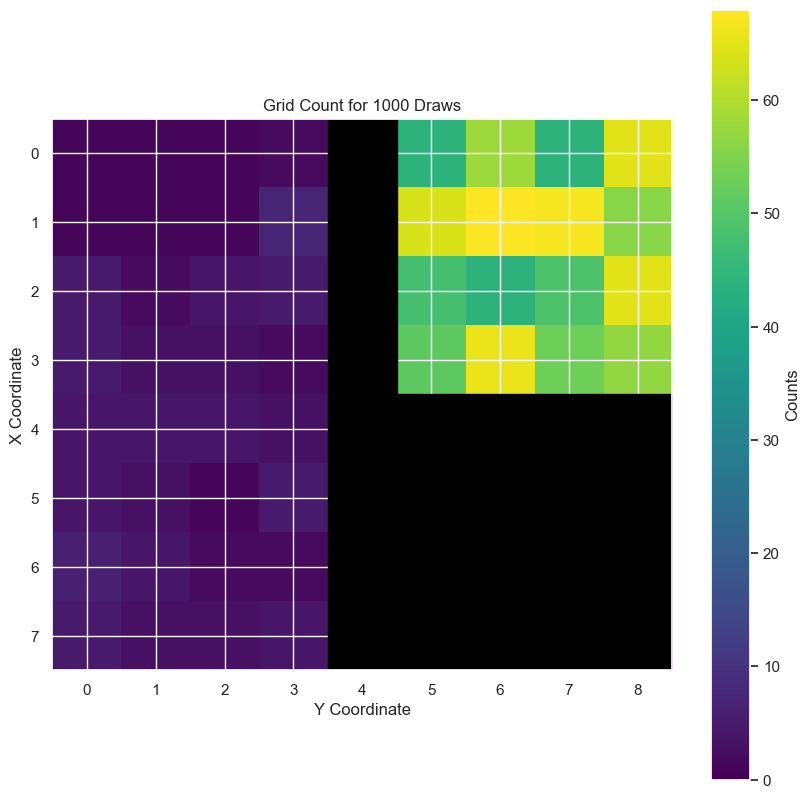

In [8]:
def plot_draws(N, prob_A, space_A, space_B):
    """
    Performs N draws using the random_select function and plots a grid with a colormap of the counts.

    Args:
        N (int): Number of draws.
        prob_A (float): Probability for selecting space A.
        space_A (tuple): Top left and bottom right corners of space A.
        space_B (tuple): Top left and bottom right corners of space B.
    """
    # Determine the dimensions of the combined grid
    min_x = min(space_A[0][0], space_B[0][0])
    max_x = max(space_A[1][0], space_B[1][0])
    min_y = min(space_A[0][1], space_B[0][1])
    max_y = max(space_A[1][1], space_B[1][1])

    # Initialize the grid with zeros
    grid = np.zeros((max_x - min_x + 1, max_y - min_y + 1))

    # Perform N draws and count occurrences
    for _ in range(N):
        x, y = random_select_starting_pos(prob_A, space_A, space_B)
        grid[x - min_x, y - min_y] += 1

    # Plot the grid
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap="viridis", interpolation="nearest", origin="lower")
    plt.colorbar(label="Counts")

    # Overlay the black squares for zero counts
    for (i, j), count in np.ndenumerate(grid):
        if count == 0:
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color="black"))

    plt.title(f"Grid Count for {N} Draws")
    plt.xlabel("Y Coordinate")
    plt.ylabel("X Coordinate")
    plt.gca().invert_yaxis()  # Ensuring the y-axis is inverted to match matrix coordinates
    plt.show()


# Example usage
N = 1000
prob_A = 0.1
space_A = ((0, 0), (7, 3))
space_B = ((0, 5), (3, 8))

plot_draws(N, prob_A, space_A, space_B)

c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.rows to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.rows` for environment variables or `env.get_wrapper_attr('rows')` that will search the reminding wrappers.
  logger.warn(
c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.cols to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.cols` for environment variables or `env.get_wrapper_attr('cols')` that will search the reminding wrappers.
  logger.warn(


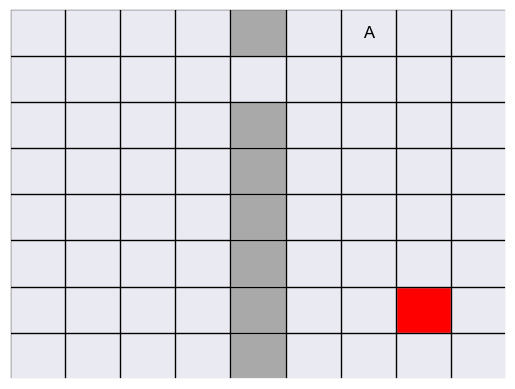

In [9]:
terminal_states = {(6, 7): 1}
start_state = (6, 1)
rows = 8
cols = 9
seed = 2
episode_limit = None
# episode_limit = 400

# random_walls = randomize_walls_positions(rows, cols, start_state, terminal_states, 0.2, seed=seed)
random_walls = {(0, 4), (2, 4), (3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (9, 4)}
# random_walls = set()

# print(random_walls)
env = make_env(
    rows,
    cols,
    start_state=start_state,
    p_success=1,
    terminal_states=terminal_states,
    seed=seed,
    walls=random_walls,
    episode_length_limit=episode_limit,
    randomize_starting_position=True,
)
env.render()

In [10]:
### Find average nr of runs
def evaluate_agent(env, num_episodes=10000):
    transition_counts = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        transition_count = 0

        while not done:
            action = env.action_space.sample()  # Take a random action
            state, reward, done, truncated, info = env.step(action)
            transition_count += 1

        transition_counts.append(transition_count)
        # logger.info(f"Episode {episode+1}: {transition_count} transitions")

    avg_transitions = np.mean(transition_counts)
    # print(f"Average number of transitions to reach terminal state: {avg_transitions}")
    return avg_transitions


# Example usage:
# Assuming `agent` is already set up and `env` is your environment
avg_transitions = evaluate_agent(env)
print(f"Average number of transitions to reach terminal state: {avg_transitions}")

Average number of transitions to reach terminal state: 311.1007


In [ ]:
import torch

states = torch.tensor(
    [
        [0, 0],  # Minimum values
        [5, 5],  # Mid values
        [9, 9],  # Maximum values
        [4, 4],
    ]
).float()


def standardize_states(states):
    """Standardize states to the range [-1, 1] based on the environment's rows and cols."""
    rows, cols = 10, 10
    states[:, 0] = 2 * (states[:, 0] / (rows - 1)) - 1
    states[:, 1] = 2 * (states[:, 1] / (cols - 1)) - 1
    return states


standardize_states(states)
# standardize_states(torch.stack(states, dim=0))

tensor([[-1.0000, -1.0000],
        [ 0.1111,  0.1111],
        [ 1.0000,  1.0000],
        [-0.1111, -0.1111]])

In [ ]:
[str(wall) for wall in random_walls]

['(4, 4)',
 '(7, 4)',
 '(2, 4)',
 '(0, 4)',
 '(3, 4)',
 '(8, 4)',
 '(5, 4)',
 '(6, 4)',
 '(9, 4)']

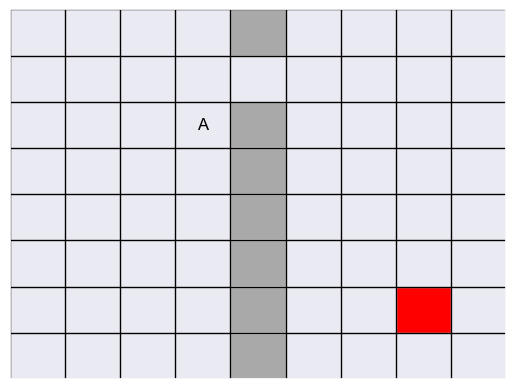

In [ ]:
from IPython.display import clear_output


def run_random_steps(env, nr_episodes=3, sleep_time=0.5):
    """
    Randomly steps through the environment and renders after each step.
    Resets the environment upon reaching a terminal state.

    Args:
        env (gym.Env): The environment to step through.
        sleep_time (float): The time to sleep between steps (in seconds).
    """
    episodes_count = 0
    while episodes_count < nr_episodes:
        done = False
        env.reset()
        while not done:
            action = env.action_space.sample()  # Take a random action
            _, _, done, _, _ = env.step(action)  # Perform the action in the environment
            clear_output(wait=True)  # Clear the output cell
            env.render()  # Render the environment
            plt.pause(0.001)  # Pause to allow the plot to update
            time.sleep(sleep_time)
        episodes_count += 1


run_random_steps(env, sleep_time=0.5)

In [ ]:
# for i in range(200):

#     next_state, reward, done, _, info = env.step(2)

#     if done:
#         print(next_state, reward, done, info, i)

In [ ]:
# def get_observation_space_shape(observation_space):
#     """Extract a shape-like tuple from a tuple of discrete spaces."""
#     return tuple(space.n for space in observation_space.spaces)

In [ ]:
# def state_to_matrix(state, env):
#     import numpy as np

#     # Extract the environment size from walls and terminal states
#     max_rows = env.rows
#     max_cols = env.cols

#     # Create the matrix
#     matrix = np.zeros((max_rows, max_cols), dtype=int)

#     # Mark walls in the matrix
#     for wall in env.walls:
#         matrix[wall[0], wall[1]] = 1  # Use 1 to indicate walls

#     # Mark terminal states in the matrix
#     for terminal, value in env.terminal_states.items():
#         matrix[terminal[0], terminal[1]] = 2

#     pos = state
#     matrix[pos[0], pos[1]] = 3  # Use 3 to indicate the agent's position

#     return matrix


# state_to_matrix(env.state, env)

In [ ]:
# state_shape = get_observation_space_shape(env.observation_space)
# state_shape

In [15]:
# env.mdp

In [16]:
# ts = next(iter(terminal_states))

# for trial in range(100000):
#     random_walls = randomize_walls_positions(rows, cols, start_state, terminal_states, 0.2, seed=trial)

#     if (start_state in random_walls) or (ts in random_walls):
#         raise ValueError("start state or terminal state in walls")

In [17]:
# transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]

# transitions_train, transitions_val = generate_train_test_split_with_valid_path(
#     transitions_list=transitions_list,
#     start_state=start_state,
#     terminal_states=terminal_states,
# )

In [40]:
### Load up a config

file_path = r"D:\Work\repos\phd-research\experiments\dqn\results\2024Jun21-204952_configs\0001_replay_buffer.type_UniqueReplayBuffer__algorithm_default\0\cfg.yaml"

# Open the YAML file and load its content into a dictionary
with open(file_path, "r") as file:
    data = yaml.safe_load(file)

opts = Namespace(**data)

logger = setup_logger(opts.full_title)

opts.seed = random.randint(0, 2**32 - 1) if opts.seed is None else opts.seed
opts_dict = namespace_to_dict(opts)
# opts_dict = vars(opts)

opts_dict

{'agent_params': {'agent': 'AgentDQN',
  'args_': {'batch_size': 32,
   'epsilon': {'decay': 80000, 'end': 0.01, 'start': 1.0},
   'gamma': 0.9,
   'loss_fcn': 'mse_loss',
   'replay_start_size': 1000,
   'target_model_update_freq': 50,
   'train_step_cnt': 4000,
   'training_freq': 4,
   'validation_enabled': False,
   'validation_epsilon': 0.001,
   'validation_step_cnt': 500}},
 'algorithm': 'default',
 'cfg_id': 1,
 'cols': 11,
 'episode_length_limit': 2000,
 'experiment': 'experiment_distributions',
 'experiment_arguments': {'algorithm': 'default',
  'replay_buffer': {'type': 'UniqueReplayBuffer'}},
 'full_title': '2024Jun21-204952_configs_replay_buffer.type=UniqueReplayBuffer; algorithm=default',
 'neural_fit_mode': 'max',
 'num_steps': 40000,
 'optim': {'args_': {'eps': 0.0003125, 'lr': 0.001}, 'name': 'Adam'},
 'out_dir': '.\\results\\2024Jun21-204952_configs\\0001_replay_buffer.type_UniqueReplayBuffer__algorithm_default\\0',
 'p_success': 1,
 'randomize_starting_position': Tru

In [41]:
opts

Namespace(agent_params={'agent': 'AgentDQN', 'args_': {'batch_size': 32, 'epsilon': {'decay': 80000, 'end': 0.01, 'start': 1.0}, 'gamma': 0.9, 'loss_fcn': 'mse_loss', 'replay_start_size': 1000, 'target_model_update_freq': 50, 'train_step_cnt': 4000, 'training_freq': 4, 'validation_enabled': False, 'validation_epsilon': 0.001, 'validation_step_cnt': 500}}, algorithm='default', cfg_id=1, cols=11, episode_length_limit=2000, experiment='experiment_distributions', experiment_arguments={'algorithm': 'default', 'replay_buffer': {'type': 'UniqueReplayBuffer'}}, full_title='2024Jun21-204952_configs_replay_buffer.type=UniqueReplayBuffer; algorithm=default', neural_fit_mode='max', num_steps=40000, optim={'args_': {'eps': 0.0003125, 'lr': 0.001}, 'name': 'Adam'}, out_dir='.\\results\\2024Jun21-204952_configs\\0001_replay_buffer.type_UniqueReplayBuffer__algorithm_default\\0', p_success=1, randomize_starting_position=True, replay_buffer={'max_size': 10000, 'n_step': 0, 'type': 'UniqueReplayBuffer'},

In [42]:
logger.info(f"Starting experiment: {opts_dict['full_title']}")

agent = setup_dqn_agent(
    config=opts_dict,
    logger=logger,
)

2024-06-21 20:51:16,416 - 2024Jun21-204952_configs_replay_buffer.type=UniqueReplayBuffer; algorithm=default - INFO - Starting experiment: 2024Jun21-204952_configs_replay_buffer.type=UniqueReplayBuffer; algorithm=default
2024-06-21 20:51:16,417 - 2024Jun21-204952_configs_replay_buffer.type=UniqueReplayBuffer; algorithm=default - INFO - Starting experiment: 2024Jun21-204952_configs_replay_buffer.type=UniqueReplayBuffer; algorithm=default
2024-06-21 20:51:16,423 - 2024Jun21-204952_configs_replay_buffer.type=UniqueReplayBuffer; algorithm=default - INFO - Loaded configuration settings.


c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.mdp to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.mdp` for environment variables or `env.get_wrapper_attr('mdp')` that will search the reminding wrappers.
  logger.warn(


2024-06-21 20:51:17,507 - 2024Jun21-204952_configs_replay_buffer.type=UniqueReplayBuffer; algorithm=default - INFO - Initialized newtworks and optimizer.


In [45]:
agent.get_settings()

{'agent_settings': {'save_checkpoints': True,
  'save_replay_buffer_cycles': True,
  'experiment_output_folder': '.\\results\\2024Jun21-204952_configs\\0001_replay_buffer.type_UniqueReplayBuffer__algorithm_default\\0',
  'experiment_name': 'experiment_distributions',
  'model_file_folder': 'model_checkpoints',
  'model_checkpoint_file_basename': 'mck',
  'replay_buffer_file': '.\\results\\2024Jun21-204952_configs\\0001_replay_buffer.type_UniqueReplayBuffer__algorithm_default\\0\\experiment_distributions_replay_buffer',
  'train_stats_file': '.\\results\\2024Jun21-204952_configs\\0001_replay_buffer.type_UniqueReplayBuffer__algorithm_default\\0\\experiment_distributions_train_stats',
  'train_step_cnt': 4000,
  'validation_enabled': False,
  'validation_step_cnt': 500,
  'validation_epsilon': 0.001,
  'replay_start_size': 1000,
  'batch_size': 32,
  'training_freq': 4,
  'target_model_update_freq': 50,
  'gamma': 0.9,
  'loss_function': 'mse_loss',
  'epsilon_by_frame': <function common.

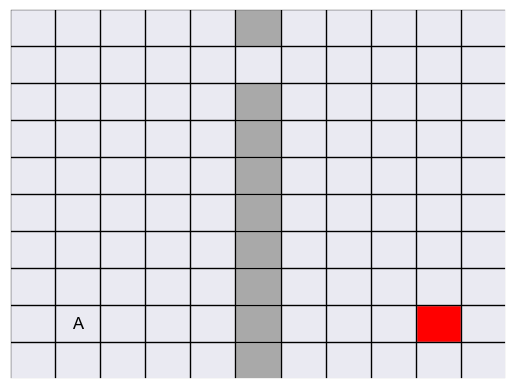

In [29]:
agent.train_env.render()

In [12]:
transitions_list = [
    (key[0], key[1], *value[0]) for key, value in agent.train_env.mdp.items()
]

experiment_data = []
for i in range(1, opts_dict["train_max_iterations"] + 1):
    agent.train(i)

    bm_error_validation = compute_validation_bellmans_error(
        agent.target_model,
        validation_transitions=transitions_list,
        error_mode=opts_dict["neural_fit_mode"],
        gamma=agent.gamma,
        logger=logger,
    )

    rb_entropy = agent.replay_buffer.calculate_buffer_entropy()

    normalized_rb = agent.replay_buffer.normalize_replay_buffer()
    normalized_rb_entropy = normalized_rb.calculate_buffer_entropy()

2024-06-13 21:36:04,445 - 2024Jun13-213541_configs_algorithm=default - INFO - Starting experiment: 2024Jun13-213541_configs_algorithm=default
2024-06-13 21:36:04,446 - 2024Jun13-213541_configs_algorithm=default - INFO - Starting experiment: 2024Jun13-213541_configs_algorithm=default
2024-06-13 21:36:04,452 - 2024Jun13-213541_configs_algorithm=default - INFO - Loaded configuration settings.
2024-06-13 21:36:05,070 - 2024Jun13-213541_configs_algorithm=default - INFO - Initialized newtworks and optimizer.
2024-06-13 21:36:05,071 - 2024Jun13-213541_configs_algorithm=default - INFO - Starting training session at: 0
2024-06-13 21:36:05,071 - 2024Jun13-213541_configs_algorithm=default - INFO - Starting training epoch at t = 0
2024-06-13 21:36:05,084 - 2024Jun13-213541_configs_algorithm=default - INFO - Episode 0 terminated at frame 399 with reward 0
2024-06-13 21:36:05,090 - 2024Jun13-213541_configs_algorithm=default - INFO - Episode 1 terminated at frame 628 with reward 1.0
2024-06-13 21:36:

NameError: name 'experiment_agent' is not defined

In [24]:
run_dqn_distribution_correction_experiment(opts_dict, logger)

2024-06-14 11:21:26,039 - 2024Jun13-213541_configs_algorithm=default - INFO - Starting experiment: 2024Jun13-213541_configs_algorithm=default
2024-06-14 11:21:26,044 - 2024Jun13-213541_configs_algorithm=default - INFO - Loaded configuration settings.
2024-06-14 11:21:26,046 - 2024Jun13-213541_configs_algorithm=default - INFO - Initialized newtworks and optimizer.
2024-06-14 11:21:26,046 - 2024Jun13-213541_configs_algorithm=default - INFO - Starting training session at: 0
2024-06-14 11:21:26,047 - 2024Jun13-213541_configs_algorithm=default - INFO - Starting training epoch at t = 0
2024-06-14 11:21:26,058 - 2024Jun13-213541_configs_algorithm=default - INFO - Episode 0 terminated at frame 399 with reward 0
2024-06-14 11:21:26,071 - 2024Jun13-213541_configs_algorithm=default - INFO - Episode 1 terminated at frame 799 with reward 0
2024-06-14 11:21:26,146 - 2024Jun13-213541_configs_algorithm=default - INFO - Episode 2 terminated at frame 1199 with reward 0
2024-06-14 11:21:26,285 - 2024Jun1

[{'epoch': 1,
  'bellman_error': 0.001459936611354351,
  'replay_buffer_entropy': 8.313411300654955,
  'normalized_replay_buffer_entropy': 8.52975112142393,
  'nr_unique_examples': 372},
 {'epoch': 2,
  'bellman_error': 0.001864887191914022,
  'replay_buffer_entropy': 8.482092485007128,
  'normalized_replay_buffer_entropy': 8.624833433590485,
  'nr_unique_examples': 396},
 {'epoch': 3,
  'bellman_error': 0.0014932170743122697,
  'replay_buffer_entropy': 8.517115112035489,
  'normalized_replay_buffer_entropy': 8.624969025817755,
  'nr_unique_examples': 396},
 {'epoch': 4,
  'bellman_error': 0.00276187970302999,
  'replay_buffer_entropy': 8.513265589839142,
  'normalized_replay_buffer_entropy': 8.625160750060425,
  'nr_unique_examples': 396},
 {'epoch': 5,
  'bellman_error': 0.002342567080631852,
  'replay_buffer_entropy': 8.472573196907778,
  'normalized_replay_buffer_entropy': 8.62517826043091,
  'nr_unique_examples': 396},
 {'epoch': 6,
  'bellman_error': 0.0013289052294567227,
  'rep

2024-06-13 21:25:04,527 - 2024Jun12-192714_configs_algorithm=default - INFO - Average number of transitions to reach terminal state: 386.8617
Average number of transitions to reach terminal state: 386.8617


In [16]:
rbs_folder = os.path.dirname(file_path)


def count_actions_in_buffer(buffer):
    actions = [transition[1] for transition in buffer]
    action_counts = Counter(actions)
    return action_counts


def collect_replay_buffer_data(buffer_directory, base_file_name, agent_replay_buffer):
    data = []
    pattern = re.compile(f".*{base_file_name}_(\d+)$")

    max_size = agent_replay_buffer.max_size
    state_dim = agent_replay_buffer.state_dim
    action_dim = agent_replay_buffer.action_dim
    n_step = agent_replay_buffer.n_step

    # Instantiate a new ReplayBuffer with the same parameters

    with os.scandir(buffer_directory) as entries:
        for entry in entries:
            if entry.is_file() and pattern.match(entry.name):
                cycle = int(pattern.search(entry.name).group(1))
                replay_buffer = ReplayBuffer(max_size, state_dim, action_dim, n_step)

                replay_buffer.load(entry.path)
                action_counts = count_actions_in_buffer(replay_buffer.buffer)
                action_counts["cycle"] = cycle
                data.append(action_counts)

    # Sort data by cycle number
    data = sorted(data, key=lambda x: x["cycle"])

    df = pd.DataFrame(data)
    df = df.fillna(0)  # Replace NaN with 0 for missing action counts
    df = df[["cycle"] + sorted([col for col in df.columns if col != "cycle"])]

    return df


df = collect_replay_buffer_data(rbs_folder, "replay_buffer", agent.replay_buffer)
df

,cycle,0,1,2,3
0,1,2062,2887,2993,2058
1,2,1003,3871,4235,891
2,3,743,4204,4277,776
3,4,165,4472,5140,223
4,5,79,4888,5004,29
5,6,33,4933,4960,74
6,7,380,4706,4843,71
7,8,147,4673,4868,312


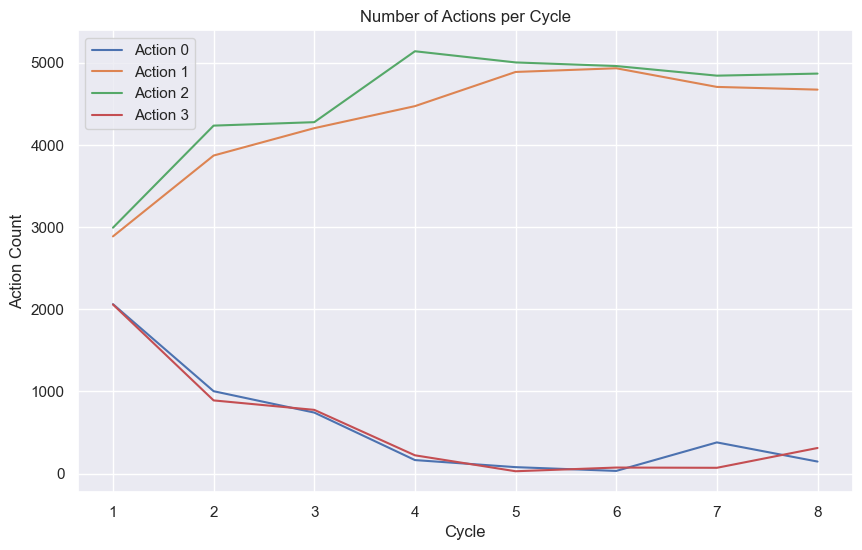

In [17]:
def plot_action_counts(df):
    plt.figure(figsize=(10, 6))

    for column in df.columns:
        if column != "cycle":
            plt.plot(df["cycle"], df[column], label=f"Action {column}")

    plt.xlabel("Cycle")
    plt.ylabel("Action Count")
    plt.title("Number of Actions per Cycle")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_action_counts(df)

In [18]:
agent.training_stats

[{'frame_stamp': 2000,
  'epsilon_greedy': 0.9505,
  'episode_rewards': {'min': 0.0,
   'max': 1.0,
   'mean': 0.7142857142857143,
   'median': 1.0,
   'std': 0.45175395145262565},
  'episode_frames': {'min': 55,
   'max': 400,
   'mean': 270.57142857142856,
   'median': 343.0,
   'std': 129.97676401447094},
  'episode_losses': {'min': 0.0004544298572000116,
   'max': 0.5181413292884827,
   'mean': 0.010644751249978553,
   'median': 0.0024925274774432182,
   'std': 0.03972142816949399},
  'episode_max_qs': {'min': 0.2697281241416931,
   'max': 1.5786041021347046,
   'mean': 0.9965944411578002,
   'median': 1.034297227859497,
   'std': 0.32727478371692326},
  'policy_trained_times': 249,
  'target_trained_times': 16,
  'epoch_time': datetime.timedelta(microseconds=370885)},
 {'frame_stamp': 4000,
  'epsilon_greedy': 0.8515,
  'episode_rewards': {'min': 1.0,
   'max': 1.0,
   'mean': 1.0,
   'median': 1.0,
   'std': 0.0},
  'episode_frames': {'min': 34,
   'max': 309,
   'mean': 168.4545

In [19]:
def collect_metrics_data(metrics):
    # Initialize an empty list to collect processed data
    data = []

    # Iterate over each metric log
    for metric in metrics:
        # Flatten the nested dictionary structure for each metric log
        flat_metric = {
            "frame_stamp": metric["frame_stamp"],
            "epsilon_greedy": metric["epsilon_greedy"],
            "policy_trained_times": metric["policy_trained_times"],
            "target_trained_times": metric["target_trained_times"],
            "epoch_time": metric["epoch_time"].total_seconds(),
        }

        # Add episode rewards statistics
        for stat_name, value in metric["episode_rewards"].items():
            flat_metric[f"episode_rewards_{stat_name}"] = value

        # Add episode frames statistics
        for stat_name, value in metric["episode_frames"].items():
            flat_metric[f"episode_frames_{stat_name}"] = value

        # Add episode losses statistics
        for stat_name, value in metric["episode_losses"].items():
            flat_metric[f"episode_losses_{stat_name}"] = value

        # Add episode max_qs statistics
        for stat_name, value in metric["episode_max_qs"].items():
            flat_metric[f"episode_max_qs_{stat_name}"] = value

        # Append the flattened metric to the data list
        data.append(flat_metric)

    # Convert the data list to a DataFrame
    df = pd.DataFrame(data)

    return df


df = collect_metrics_data(agent.training_stats)
df

,frame_stamp,epsilon_greedy,policy_trained_times,target_trained_times,epoch_time,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,...,episode_losses_min,episode_losses_max,episode_losses_mean,episode_losses_median,episode_losses_std,episode_max_qs_min,episode_max_qs_max,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std
0,2000,0.9505,249,16,0.370885,0.0,1.0,0.714286,1.0,0.451754,...,0.000454,0.518141,0.010645,0.002493,0.039721,0.269728,1.578604,0.996594,1.034297,0.327275
1,4000,0.8515,500,40,0.711384,1.0,1.0,1.000000,1.0,0.000000,...,0.000112,0.039725,0.001465,0.000721,0.004040,0.385277,1.295343,0.776240,0.758651,0.189340
2,6000,0.7525,500,40,0.759700,0.0,1.0,0.941176,1.0,0.235294,...,0.000067,0.010513,0.001331,0.000528,0.001846,0.287574,0.749366,0.509500,0.514012,0.103477
3,8000,0.6535,500,40,0.762813,1.0,1.0,1.000000,1.0,0.000000,...,0.000108,0.013350,0.001667,0.000645,0.002340,0.205886,0.759716,0.441932,0.438855,0.122661
4,10000,0.5545,500,40,1.108434,1.0,1.0,1.000000,1.0,0.000000,...,0.000070,0.024425,0.002070,0.000760,0.002632,0.199266,0.755253,0.441790,0.421910,0.142889
5,12000,0.4555,500,40,0.798875,1.0,1.0,1.000000,1.0,0.000000,...,0.000142,0.017064,0.002681,0.000872,0.003192,0.193455,0.812316,0.463894,0.444582,0.160618
6,14000,0.3565,500,40,0.792685,1.0,1.0,1.000000,1.0,0.000000,...,0.000124,0.016634,0.003053,0.001438,0.003096,0.197966,0.805351,0.468821,0.465604,0.143447
7,16000,0.2575,500,40,0.830138,1.0,1.0,1.000000,1.0,0.000000,...,0.000180,0.022896,0.004402,0.003846,0.004233,0.161266,0.749951,0.413827,0.393829,0.150006
8,18000,0.1585,500,40,0.820915,1.0,1.0,1.000000,1.0,0.000000,...,0.000240,0.019044,0.003546,0.003345,0.003089,0.199740,0.846027,0.492783,0.470440,0.170146
9,20000,0.0595,500,40,1.223892,1.0,1.0,1.000000,1.0,0.000000,...,0.000313,0.020954,0.004924,0.004590,0.003516,0.202437,0.877496,0.518028,0.506848,0.167219


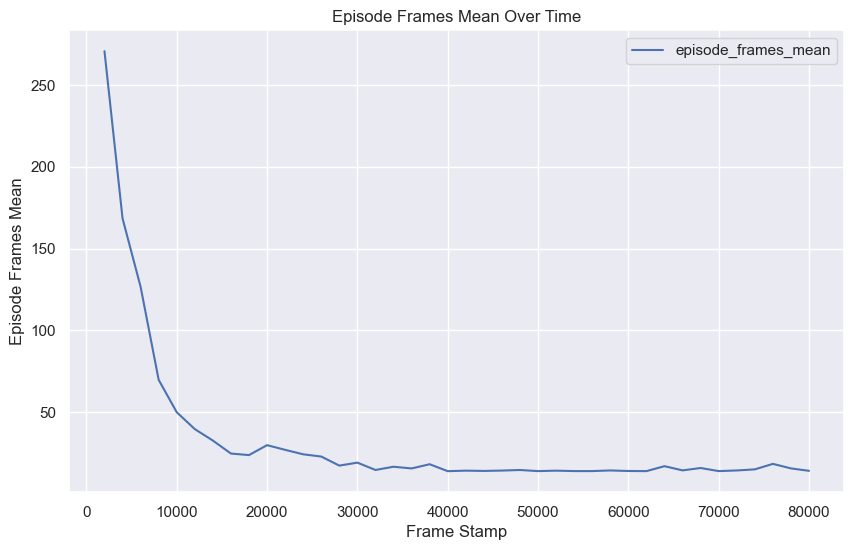

In [20]:
metric = "episode_frames_mean"
plt.figure(figsize=(10, 6))
plt.plot(df["frame_stamp"], df[metric], label=metric)
plt.xlabel("Frame Stamp")
plt.ylabel(metric.replace("_", " ").title())
plt.title(f'{metric.replace("_", " ").title()} Over Time')
plt.legend()
plt.grid(True)
plt.show()

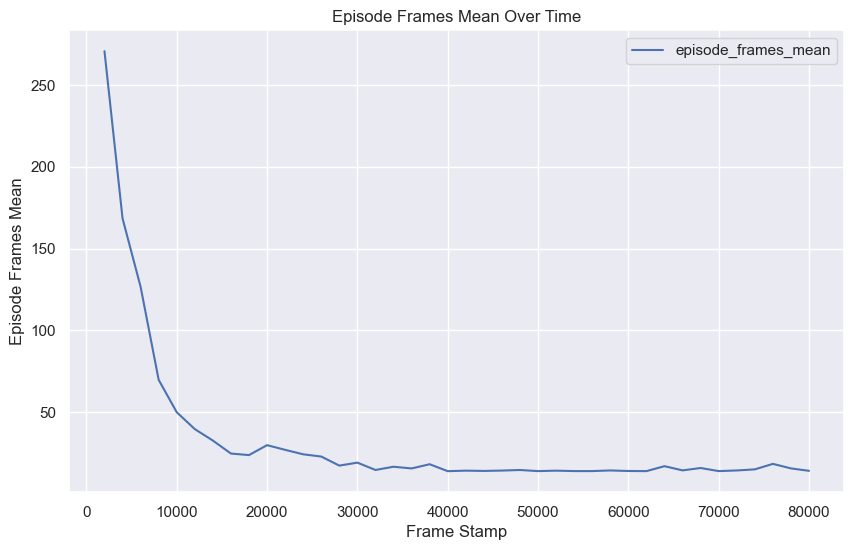

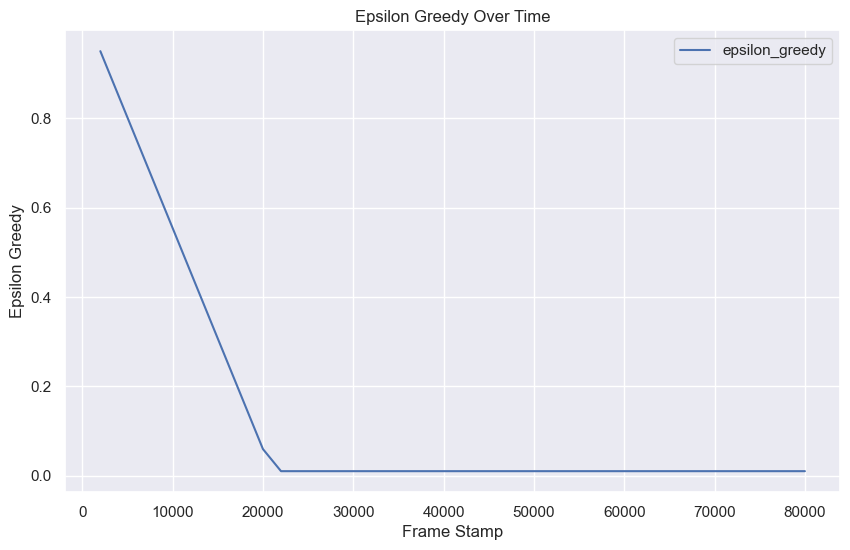

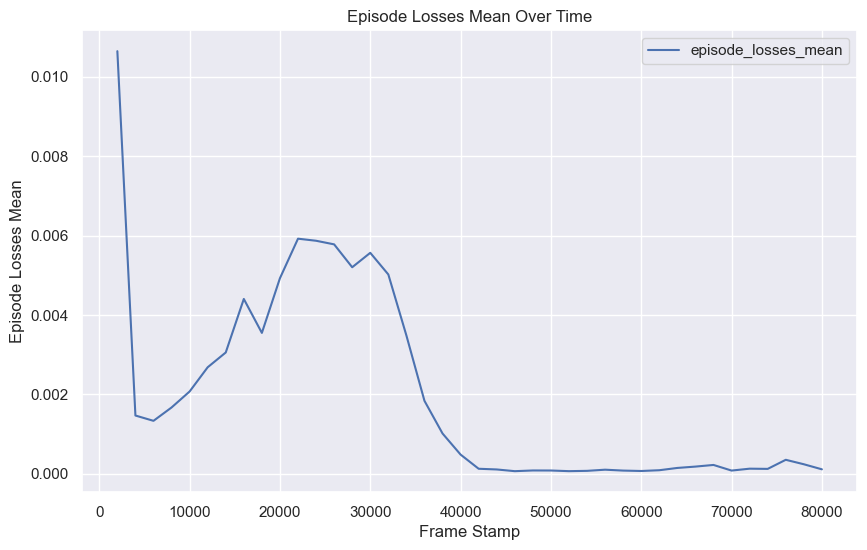

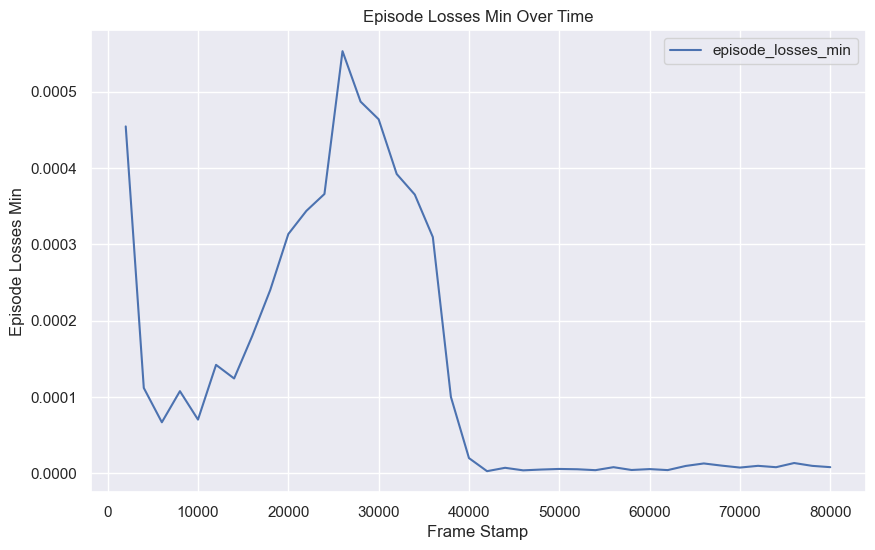

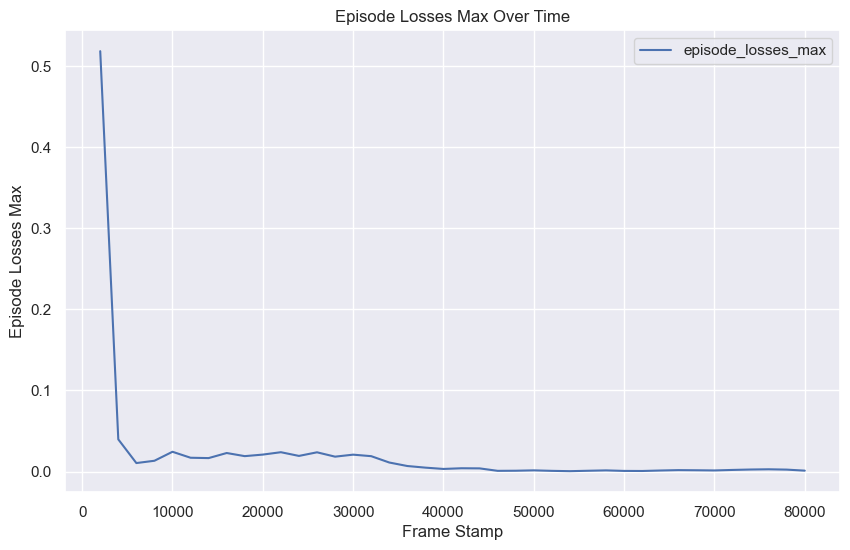

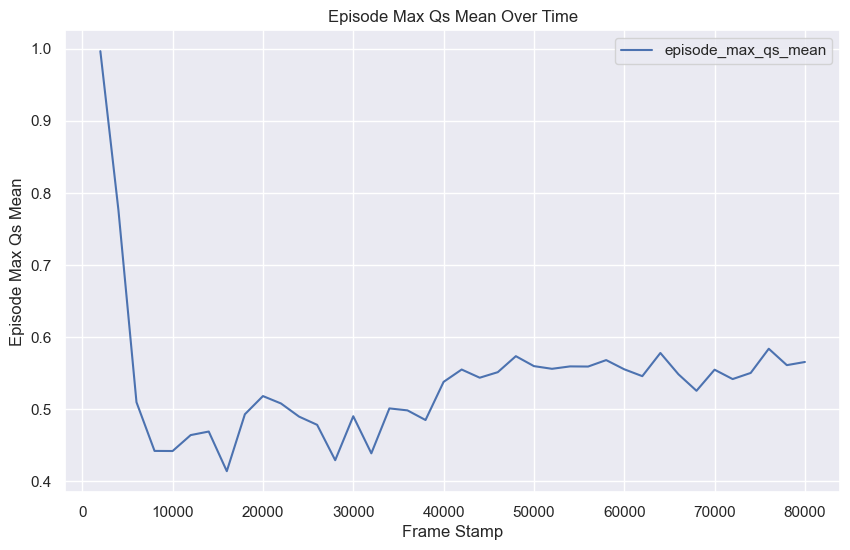

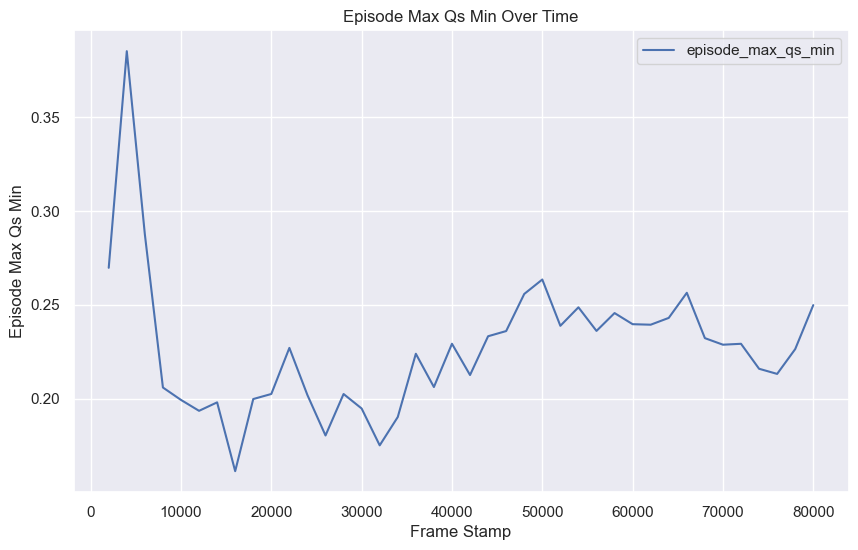

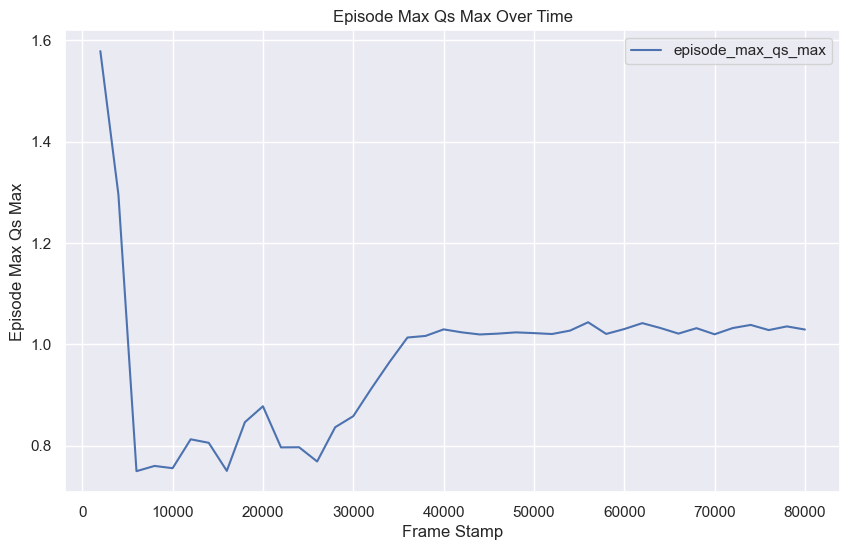

In [21]:
def plot_metrics(df):
    metrics_to_plot = [
        "episode_frames_mean",
        "epsilon_greedy",
        "episode_losses_mean",
        "episode_losses_min",
        "episode_losses_max",
        "episode_max_qs_mean",
        "episode_max_qs_min",
        "episode_max_qs_max",
    ]

    for metric in metrics_to_plot:
        if metric in df.columns:
            plt.figure(figsize=(10, 6))
            plt.plot(df["frame_stamp"], df[metric], label=metric)
            plt.xlabel("Frame Stamp")
            plt.ylabel(metric.replace("_", " ").title())
            plt.title(f'{metric.replace("_", " ").title()} Over Time')
            plt.legend()
            plt.grid(True)
            plt.show()


# Example usage
plot_metrics(df)

In [22]:
# rb_buffer = agent.replay_buffer
# buffer = rb_buffer.buffer

# examples = [(transition[0], transition[1]) for transition in buffer]
# example_strings = [f"{state}_{action}" for state, action in examples]
# unique_examples, counts = np.unique(example_strings, return_counts=True)
# example_entropy = entropy(counts, base=2)

In [23]:
# len(unique_examples)

In [ ]:
# counts.sort()
# counts

In [ ]:
# example_entropy

In [ ]:
# normalized_rb = rb_buffer.normalize_replay_buffer()
# normalized_rb_entropy = normalized_rb.calculate_buffer_entropy()
# buffer_normed = normalized_rb.buffer


# examples_normalized = [(transition[0], transition[1]) for transition in buffer_normed]
# example_strings_normalized = [f"{state}_{action}" for state, action in examples_normalized]
# len(example_strings_normalized)

In [ ]:
# unique_examples, counts = np.unique(example_strings_normalized, return_counts=True)
# len(unique_examples)

In [ ]:
# counts

In [ ]:
# example_entropy_normed = entropy(counts, base=2)
# example_entropy_normed

In [ ]:
# normalized_rb_entropy

In [30]:
# def randomly_step_through_env(env):
#     is_terminated = False
#     truncated = False
#     visited_states = set()
#     recorded_states = []

#     while not is_terminated and not truncated:
#         # Sample a random action from the action space
#         action = env.action_space.sample()

#         # Take a step in the environment
#         s_prime, reward, is_terminated, truncated, info = env.step(action)

#         # Convert state to a hashable type (e.g., tuple) if it's not already
#         s_prime_hashable = (
#             tuple(s_prime) if isinstance(s_prime, (list, np.ndarray)) else s_prime
#         )

#         # Check if the state is new
#         if s_prime_hashable not in visited_states:
#             visited_states.add(s_prime_hashable)
#             recorded_states.append(s_prime)
#             print(
#                 f"New State: {s_prime}, Action: {action}, Reward: {reward}, Terminated: {is_terminated}, Truncated: {truncated}, Info: {info}"
#             )

#     print("Reached terminal state or truncated.")
#     return recorded_states


# # Example usage:
# # Assuming `train_env` is your environment instance
# # randomly_step_through_env(train_env)

In [35]:
def randomly_step_through_env(env, num_steps=100):
    is_terminated = False
    truncated = False
    recorded_transitions = []

    for _ in range(num_steps):
        if is_terminated or truncated:
            break

        # Sample a random action from the action space
        action = env.action_space.sample()

        # Take a step in the environment
        s_prime, reward, is_terminated, truncated, info = env.step(action)

        # Record transition
        recorded_transitions.append((env.state, action, reward, s_prime, is_terminated))
        env.state = s_prime

    return recorded_transitions


# Create environments
env = GridWorld()

# Generate transitions
transitions = randomly_step_through_env(env, num_steps=200)

# Create replay buffers
normal_replay_buffer = ReplayBuffer(max_size=100, state_dim=(5, 5), n_step=1)
unique_replay_buffer = UniqueReplayBuffer(max_size=100, state_dim=(5, 5), n_step=1)

# Add transitions to both buffers
for transition in transitions:
    normal_replay_buffer.append(*transition)
    unique_replay_buffer.append(*transition)

# Print the length of both buffers
print("Normal Replay Buffer Length:", len(normal_replay_buffer))
print("Unique Replay Buffer Length:", len(unique_replay_buffer))

# Print a few transitions from both buffers to verify uniqueness
print("\nSample Transitions from Normal Replay Buffer:")
for _ in range(5):
    print(normal_replay_buffer.buffer[random.randint(0, len(normal_replay_buffer) - 1)])

print("\nSample Transitions from Unique Replay Buffer:")
for _ in range(5):
    print(unique_replay_buffer.buffer[random.randint(0, len(unique_replay_buffer) - 1)])

Normal Replay Buffer Length: 100
Unique Replay Buffer Length: 62

Sample Transitions from Normal Replay Buffer:
((1, 0), 0, -0.1, (1, 0), False)
((0, 1), 0, -0.1, (0, 1), False)
((0, 4), 0, -1, (0, 4), False)
((3, 1), 3, -0.1, (3, 1), False)
((1, 0), 2, -0.1, (1, 0), False)

Sample Transitions from Unique Replay Buffer:
((2, 2), 2, -0.1, (2, 2), False)
((0, 4), 1, -0.1, (0, 4), False)
((0, 3), 0, -0.1, (0, 3), False)
((2, 1), 2, -0.1, (2, 1), False)
((3, 0), 3, -0.1, (3, 0), False)


In [ ]:
# loss_records, bm_error = run_distribution_correction_experiment(
#         tau=opts.tau,
#         seed=opts.seed,
#         run_id=opts.run_id,
#         rows=opts.rows,
#         cols=opts.cols,
#         start_state=opts.start_state,
#         p_success=opts.p_success,
#         terminal_states=opts.terminal_states,
#         num_steps=opts.num_steps,
#         gamma=opts.gamma,
#         min_samples=opts.min_samples,
#         batch_size=opts.batch_size,
#         train_max_iterations=opts.train_max_iterations,
#         neural_fit_mode=opts.neural_fit_mode,
#         algorithm=opts.algorithm,
#         logger=logger,
#     )

In [ ]:
# loss_records